In [ ]:
# notebook last tested with abtem version 1.0.0beta8

from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import matplotlib.pyplot as plt

from abtem import *

# HRTEM simulation of nanoparticle

We build a nanoparticle with around 2000 atoms as a Wulff construction. We add vacuum to all sides of the model and the nanoparticle is rotated to align with the <110> zone axis.

In [ ]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets

esurf = [1.0, 1.1, 0.9] # Relative surface energies

size = 500 # Target number of atoms

atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above'))

atoms.center(vacuum=5)

atoms.rotate(45, 'x', center='cop')

show_atoms(atoms)

We create the electrostatic potential. In this example, we use the infinite projection scheme to allow the notebook to run with low computational resources. The sampling used here is also a bit rough.

In [ ]:
potential = Potential(atoms, 
                      gpts=512, 
                      slice_thickness=2, 
                      parametrization='kirkland', 
                      projection='infinite')

potential.sampling

To simulate temperature effects uncomment the code below.

In [46]:
sigmas = {'Au': .1} # standard deviations of thermal vibrations
num_configs = 8 # number of frozen phonon configurations

frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
potential = Potential(frozen_phonons, gpts=512, slice_thickness=1, parametrization='kirkland', projection='infinite')

We create the incoming plane wave and start the multislice simulation.

In [47]:
wave = PlaneWave(
    energy=300e3 # acceleration voltage in eV
)

exit_wave = wave.multislice(potential)

exit_wave.array

dask.array<stack, shape=(8, 512, 512), dtype=complex64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>

Note, we get out a stack of exit waves, one for each frozen phonon configuration.

In [48]:
exit_wave.compute(pbar=True)

[########################################] | 100% Completed | 23.4s


We show the intensity of the first exit wave and the intensity of the thermal ensemble. To get get the intensity of the thermal ensemble, we take the mean across the ensemble dimension after calculating the intensity.

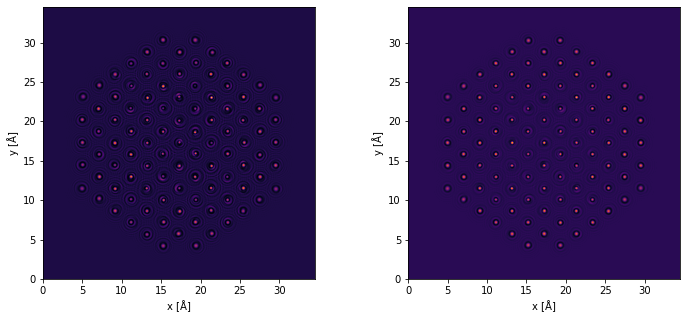

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

exit_wave.intensity().show(ax=ax1, cmap='inferno');

exit_wave.intensity().mean(0).show(ax=ax2, cmap='inferno');

We create and show the contrast transfer function, see [docs](https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html) for a description of the parameters.

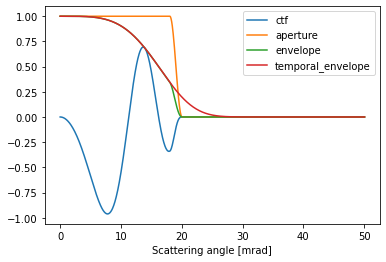

In [50]:
ctf = CTF(
    energy = wave.energy,
    semiangle_cutoff = 20, # mrad
    focal_spread = 40, # Å
    defocus = -160, # Å
    Cs = -7e-6 * 1e10, # Å
)

ctf.show(max_semiangle=50);

To simulate an image we apply the contrast transfer function of the objective lens. 

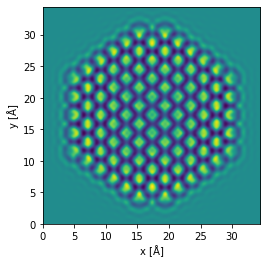

In [51]:
image_wave = exit_wave.apply_ctf(ctf)

image_wave.intensity().mean(0).show();

We can get the diffraction pattern up to a chosen scattering angle, we can block the zero order spot and display it on a power scale.

1


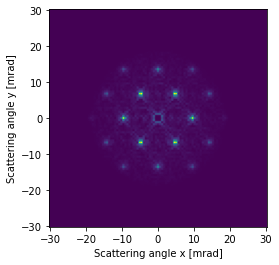

In [70]:
image_wave.diffraction_patterns(max_angle=30, block_direct=1, ).show(power=.5);